In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Wedge

# Seminar L03

Suppose that the trajectory of a robot can be described by a vector $p_i=\begin{bmatrix}{x}_i \\ {y}_i \\ \theta_i\end{bmatrix}$ which is a location of the robot $(x,y)$ and a sclar $\theta_i$ which is its heading (in radians).

<img src="heading.png" width="480" height="360">

# 1 Marginalization of orientation
Let's assume we have the following Gussian distribution of the 2D pose $p$:

$$ p(\theta, x,y) = \mathcal{N}(\begin{bmatrix}x \\ y \\ \theta\end{bmatrix} ; \begin{bmatrix}1 \\ 1 \\ 0.3 \end{bmatrix}, \begin{bmatrix}0.3 & 0 & 0.1 \\ 0 & 0.2 & 0.2 \\ 0.1 & 0.2 & 0.5  \end{bmatrix} )$$


The problem is to marginalize the orientation variable $\theta$:

$$p(\theta) = \int \int p(\theta, x,y) dx dy = \mathcal{N}(\theta; \mu_{\theta}, \Sigma_{\theta})$$

In [13]:
cov = np.array([[0.3, 0, 0.1],\
                [0, 0.2, 0.2],
                [0.1, 0.2, 0.5]])

In [2]:
# TODO. Your answer here
mu_th = 0.3
sigma_th = 0.5
th = np.random.normal(mu_th, sigma_th, 1000)

# 2 Conditioning
Now, we have access to the position variables. Calculate the new conditioned distribution $p(\theta | x,y)$ for $x=1.1$ and $y = 1.1$

$$p(x_a|x_b)=\mathcal{N}(x_a; \mu_a + \Sigma_{ab}\Sigma_b^{-1}(x_b - \mu_b), \Sigma_a - \Sigma_{ab}\Sigma_b^{-1}\Sigma_{ba})$$


In [18]:
S_b_inv = np.linalg.inv(cov[:2, :2])
S_ab = cov[2, :2]
S_a = cov[2, 2]
S_ba = S_ab.T
mu = 0.3 + S_ab @ S_b_inv @ np.array([[1.1 - 1], [1.1 - 1]])
S = S_a - S_ab @ S_b_inv @ S_ba
print(mu)
print(S)

[0.43333333]
0.26666666666666666


# 3 Robot trajectory: Joint distribution marginalization
While the data from a robot were read some errors occurred. Due to that, the heading values were lost and the positions of the robot are slightly off. Luckily, we've managed to recover errors in positioning, but the exact orientations are still unknown.
Some residual data suggest that heading values are distributed normally that is defined by PDF with the following mean and covariance as well as depend on errors in positioning:

$$\begin{bmatrix}p_1 \\ p_2 \\ p_3 \\ p_4 \\ p_5\end{bmatrix} \sim \mathcal{N}\Bigg(\begin{bmatrix}\mu_{p_1} \\ \mu_{p_2} \\ \mu_{p_3} \\ \mu_{p_4} \\ \mu_{p_5} \end{bmatrix}, \begin{bmatrix}\Sigma_{p_1} & 0 & 0 & 0 & 0 \\ 0 & \Sigma_{p_2} & 0 & 0 & 0 \\ 0 & 0  & \Sigma_{p_3} & 0 & 0 \\ 0 & 0 & 0  & \Sigma_{p_4} & 0  \\ 0 & 0 & 0 & 0 &\Sigma_{p_5} \end{bmatrix} \Bigg)$$

Where $p_i = \begin{bmatrix}dx_i \\ dy_i \\ \theta_i\end{bmatrix}$, $\mu_{p_i}=\begin{bmatrix}0 \\ 0 \\ {\mu_\theta}_i\end{bmatrix}$ and $\Sigma_{p_i} = \begin{bmatrix}0.3 & 0 & 0.1 \\ 0 & 0.2 & 0.2 \\ 0.1 & 0.2 & 0.5  \end{bmatrix}$

Knowing positions of the robot with errors (variable $robot\_positions$) and mean heading values ${\mu_\theta}_i$ for each position (variable $mu\_theta$) we want to estimate the uncertainty of our guess about heading values by $\textbf{marginalizing}$ it out of the PDF. Calculate 1-sigma of the PDF (store it in the variable $sigma\_theta\_m$ as a column vector of size $n \times 1$) and plot the 1-sigma sector using the code provided below

In [19]:
robot_positions = np.array([[2, 1],
                            [4, 3],
                            [6, -1],
                            [8, 1.5],
                            [10, -0.5]])

# Mean headings in radians
mu_theta = np.array([[np.pi / 4 - np.pi / 16],
                     [-np.pi / 4 - 2 * np.pi / 16],
                     [np.pi / 4 + 2.7 * np.pi / 16],
                     [-np.pi / 2 + 0.4 * np.pi / 16],
                     [0]])

In [29]:
# Calculate the marginal PDF of theta and get 1-sigma of the bearings guess for each position

# TODO. Change that line
sigma_theta_m = np.array([[0.5], [0.5], [0.5], [0.5], [0.5]]) ** 0.5

In [30]:
def plot_headings(_ax, positions, _mu_theta, sigma1, color):
    _mu_theta = np.rad2deg(_mu_theta)
    sigma1 = np.rad2deg(sigma1)
    
    for pos, mu, sigma in zip(positions, _mu_theta, sigma1):
        sec_start = mu - sigma
        sec_end = mu + sigma
        
        mu_rad = np.deg2rad(mu)
        heading = np.concatenate([np.cos(mu_rad), np.sin(mu_rad)], axis=0)[None] * 0.5
        heading = np.concatenate([pos[None], pos[None] + heading], axis=0)
        
        _ax.plot(heading[:, 0], heading[:, 1], color='black', alpha=0.8)
        _ax.add_artist(Wedge(pos, 0.5, sec_start[0], sec_end[0], color=color, alpha=0.6))


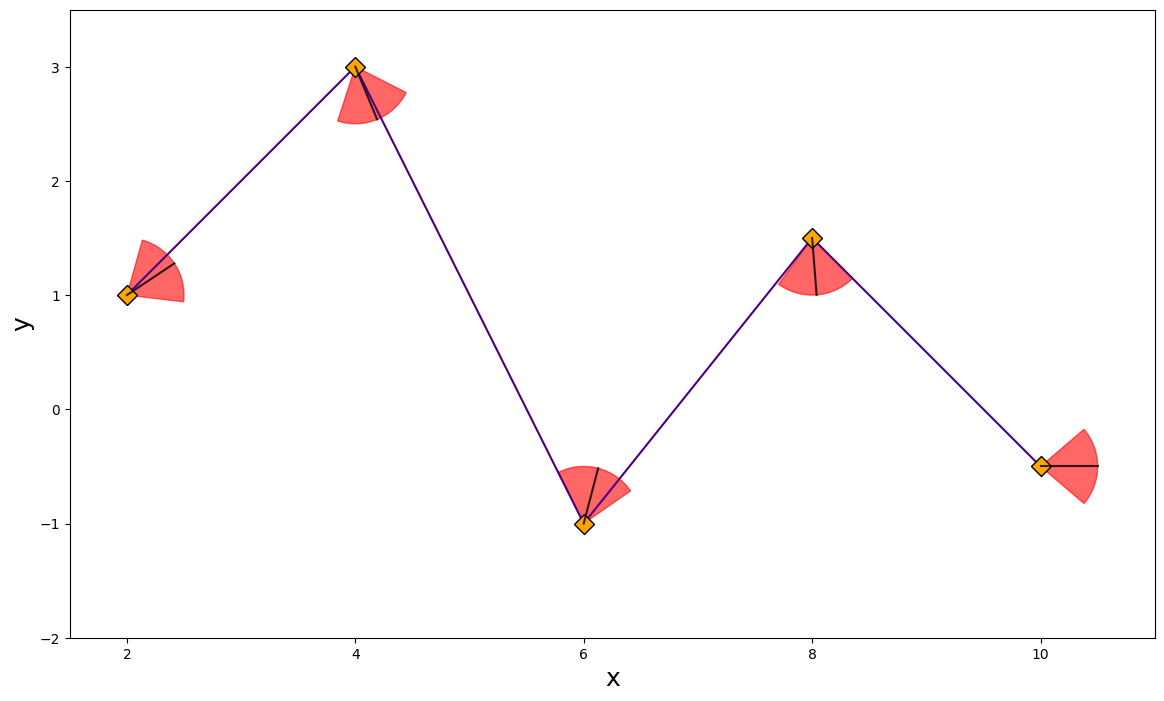

In [31]:
fig = plt.figure(figsize=(14, 9))

ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax.set_ylim(-2, 3.5)
ax.set_xlim(1.5, 11)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)


ax.plot(robot_positions[:, 0], robot_positions[:, 1], 
        color="indigo",
        marker='D', markersize=10, markerfacecolor='orange', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax, robot_positions, mu_theta, sigma_theta_m, 'red')

plt.show()

# 4 Joint distribution conditioning
Now, we want to correct robot's positions using recovered data (variable $positions\_err$) as well as our guess on the headigns 1-sigma estimate by utilizing the fact that we know $dx_i$ and $dy_i$. $\textbf{Condition}$ $\theta_i$ of PDF $\textbf{on}$ $dx_i$ and $dy_i$ and use their values to recalculate mean and covariance of $p(\theta_i|x_i, y_i)$. Plot the updated robot trajectory and 1-sigma sector next to the old one in is same manner as in 2.1.

In [ ]:
dx = np.array([[-0.1931705 ],
               [ 0.1224564 ],
               [-0.11136686],
               [ 0.28472354],
               [-0.29425286]])

dy = np.array([[ 0.16510238],
               [-0.00937599],
               [-0.3699997 ],
               [ 0.3970382 ],
               [ 0.08117404]])


In [ ]:
# TODO. Change theses lines

new_robot_positions = 
new_mu_theta = 
sigma_theta_c = 

In [ ]:
fig2 = plt.figure(figsize=(14, 9))

ax2 = fig2.add_subplot(1, 1, 1, aspect='equal')

ax2.set_ylim(-2, 3.5)
ax2.set_xlim(1.5, 11)
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('y', fontsize=18)


ax2.plot(robot_positions[:, 0], robot_positions[:, 1], 
         color="indigo",
         marker='D', markersize=10, markerfacecolor='orange', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax2, robot_positions, mu_theta, sigma_theta_m, 'red')
        
ax2.plot(new_robot_positions[:, 0], new_robot_positions[:, 1], 
         color="darkgreen",
         marker='X', markersize=10, markerfacecolor='green', markeredgewidth=1.0, markeredgecolor=(0, 0, 0, 1))
plot_headings(ax2, new_robot_positions, new_mu_theta, sigma_theta_c, 'purple')

plt.show()

<b>Question:</b> If cross-correlation terms are zero then will the conditioning have any effect on the variable for which conditioning is performed?